# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 42

## Student 1 
### Name : Otte van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nbformat
from tqdm import tqdm
from flexfringe import FlexFringe
from sklearn.metrics.pairwise import cosine_similarity



nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 332


## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [84]:
# Specify the columns you want to read as strings
string_columns = ['sTos', 'dTos']

data = "dataset_lab3/dataset_10/capture20110818.binetflow"
df = pd.read_csv(data)
df1 = pd.read_csv(data, dtype={col: str for col in string_columns})
print(df1['TotPkts'].unique())
print(len(df1['TotPkts'].unique()))
print(df1.iloc[0:5])

infected_hosts = ['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193','147.32.84.204', '147.32.84.205', '147.32.84.206','147.32.84.207', '147.32.84.208', '147.32.84.209']

[    4    15     3 ...   762 10581  1452]
3190
                    StartTime         Dur Proto         SrcAddr  Sport    Dir  \
0  2011/08/18 10:21:46.633335    1.060248   tcp    93.45.239.29   1611     ->   
1  2011/08/18 10:19:49.027650  279.349152   tcp  62.240.166.118   1031    <?>   
2  2011/08/18 10:22:07.160628  166.390015   tcp   147.32.86.148  58067     ->   
3  2011/08/18 10:26:02.052163    1.187083   tcp     147.32.3.51   3130     ->   
4  2011/08/18 10:26:52.226748    0.980571   tcp   88.212.37.169   3134     ->   

          DstAddr  Dport    State sTos dTos  TotPkts  TotBytes  SrcBytes  \
0   147.32.84.118   6881     S_RA    0    0        4       252       132   
1   147.32.84.229  13363  SRPA_PA    0    0       15      1318       955   
2  66.235.132.232     80    SR_SA    0    0        3       212       134   
3    147.32.84.46  10010     S_RA    0    0        4       244       124   
4   147.32.84.118   6881     S_RA    0    0        4       244       124   

         

In [ ]:
df1 = pd.read_csv(data, dtype={col: str for col in string_columns})
df1['bytes_per_second'] = df1['TotBytes'] / df1['Dur']

# Use the value_counts() function to count the occurrences of each value in the 'SrcAddr' column
srcaddr_counts = df1['SrcAddr'].value_counts()

# Get the most occurring value by accessing the first element of the resulting series
most_common_value = srcaddr_counts.index[0]

# Print the most occurring value
print("Most occurring value in 'SrcAddr':", most_common_value, ' with ', srcaddr_counts[0], ' occurences, out of ', len(df1), ' occurences in total')

print(df1['TotPkts'].unique())
print(len(df1['TotPkts'].unique()))

df1_infected = df1[df1['SrcAddr'].isin(infected_hosts)]
df1_not_infected = df1[~df1['SrcAddr'].isin(infected_hosts)]

print(len(df1_infected), len(df1_not_infected), len(df1))

# Discretize numeric columns using percentiles
for column in df1.columns:
    if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
        df1[column] = pd.qcut(df1[column], q=20, labels=False, duplicates='drop')

# print lens of all the columns
for column in df1.columns:
    if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
        print("Column '{}' has {} unique values".format(column, len(df1[column].unique())))
        print(df1[column].unique())


Most occurring value in 'SrcAddr': 147.32.84.138  with  211967  occurences, out of  1309791  occurences in total
[    4    15     3 ...   762 10581  1452]
3190
30433 1279358 1309791


c:\python39\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Column 'Dur' has 19 unique values
[13 16 15 14 17  0 18  9  1 11  8  3  2 12  7  4 10  5  6]
Column 'TotPkts' has 9 unique values
[2 6 1 4 0 3 7 8 5]
Column 'TotBytes' has 17 unique values
[ 6 12  3  5  9  2  0  7 13  8 11 14 16  1 15 10  4]
Column 'SrcBytes' has 18 unique values
[ 8 13  9 10  0 15  3 12 14 16 17 11  2  4  5  1  7  6]
Column 'bytes_per_second' has 19 unique values
[ 4  1  3  2  0 18  9 10  6 13  7  8  5 11 12 14 16 15 17]


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [82]:
# Filter columns that are either integers or floats
numeric_cols_infected = df1[df1['SrcAddr'] == infected_hosts[1]].select_dtypes(include=['int', 'float'])
numeric_cols_other = df1[df1['SrcAddr'] != infected_hosts[1]].select_dtypes(include=['int', 'float'])

# Calculate the average and standard deviation for df_srcaddr_147
avg_values_147 = numeric_cols_infected.mean()
std_values_147 = numeric_cols_infected.std()
print(f'calculated for 147')

# Calculate the average and standard deviation for df_srcaddr_other
avg_values_other = numeric_cols_other.mean()
std_values_other = numeric_cols_other.std()
print('calculated for other')

# Print the average and standard deviation side by side
print(f"{'Column':<15} {'Average (147)':<15} {'Std Deviation (147)':<20} {'Average (Other)':<15} {'Std Deviation (Other)':<20}")
print("-" * 90)
for column in avg_values_147.index:
    avg_147 = avg_values_147[column]
    std_147 = std_values_147[column]
    avg_other = avg_values_other[column]
    std_other = std_values_other[column]
    print(f"{column:<15} {avg_147:<15.2f} {std_147:<20.2f} {avg_other:<15.2f} {std_other:<20.2f}")

calculated for 147
calculated for other
Column          Average (147)   Std Deviation (147)  Average (Other) Std Deviation (Other)
------------------------------------------------------------------------------------------
Dur             1.68            5.06                 8.60            5.66                
TotPkts         0.29            1.33                 1.74            2.63                
TotBytes        11.31           1.07                 7.54            4.89                
SrcBytes        13.32           1.14                 7.93            5.09                
bytes_per_second 16.39           4.86                 9.39            5.66                


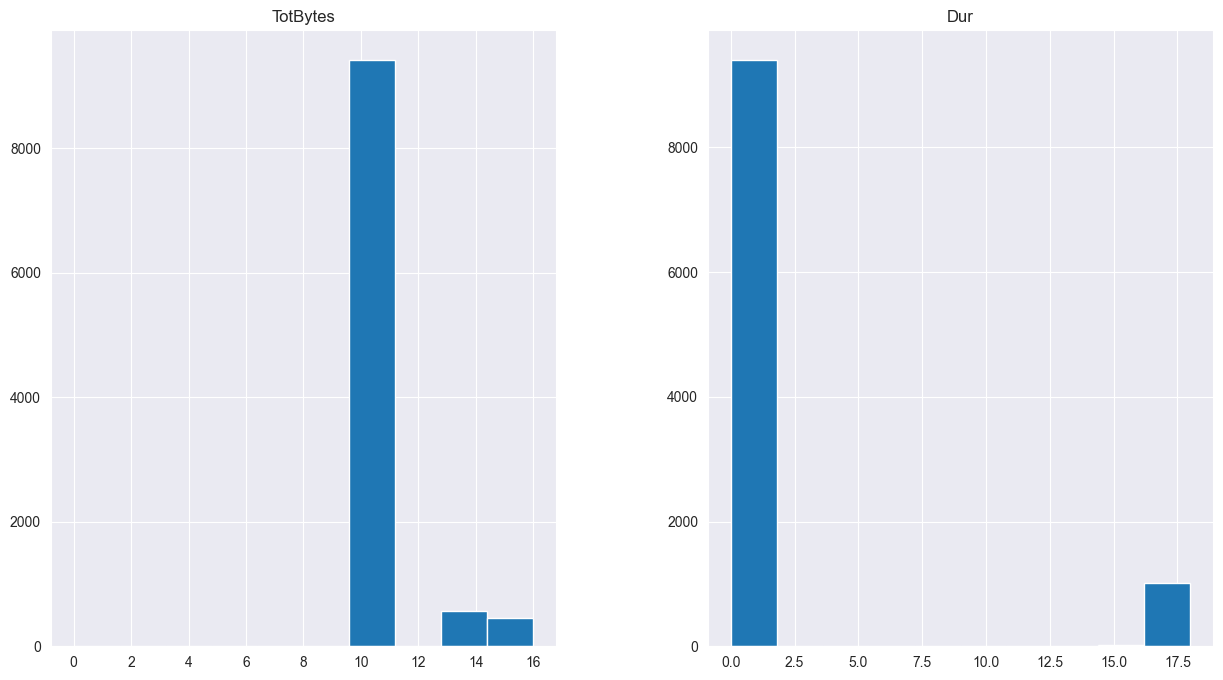

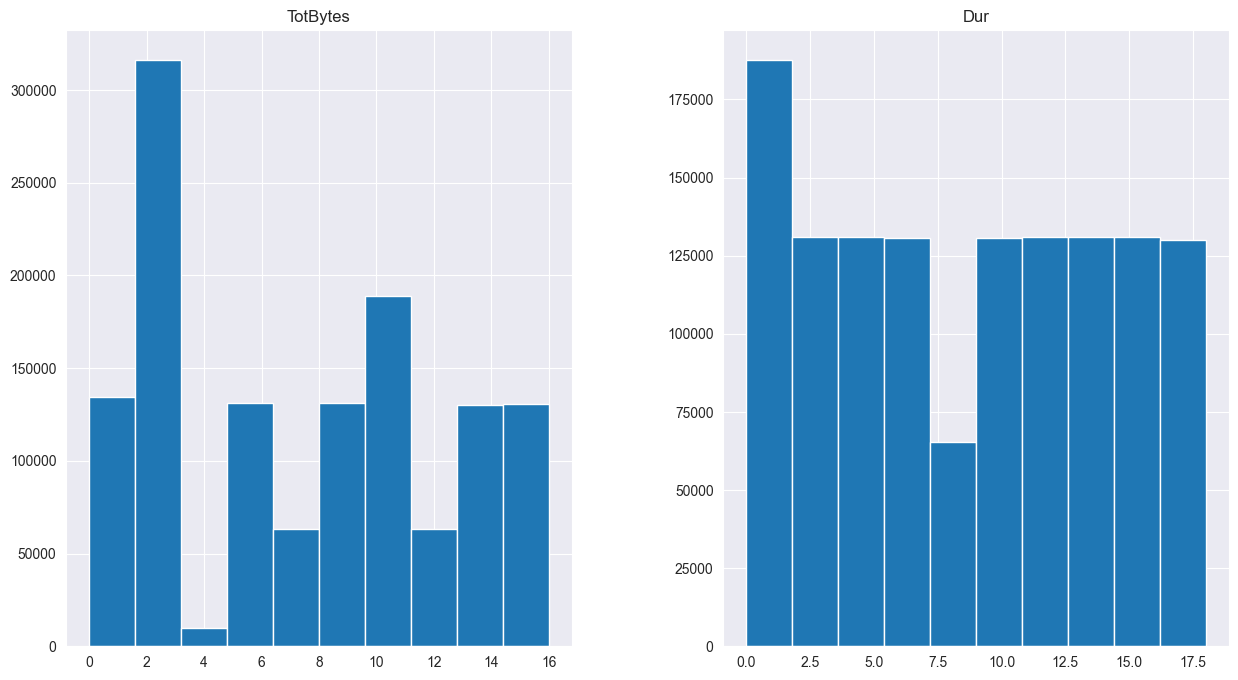

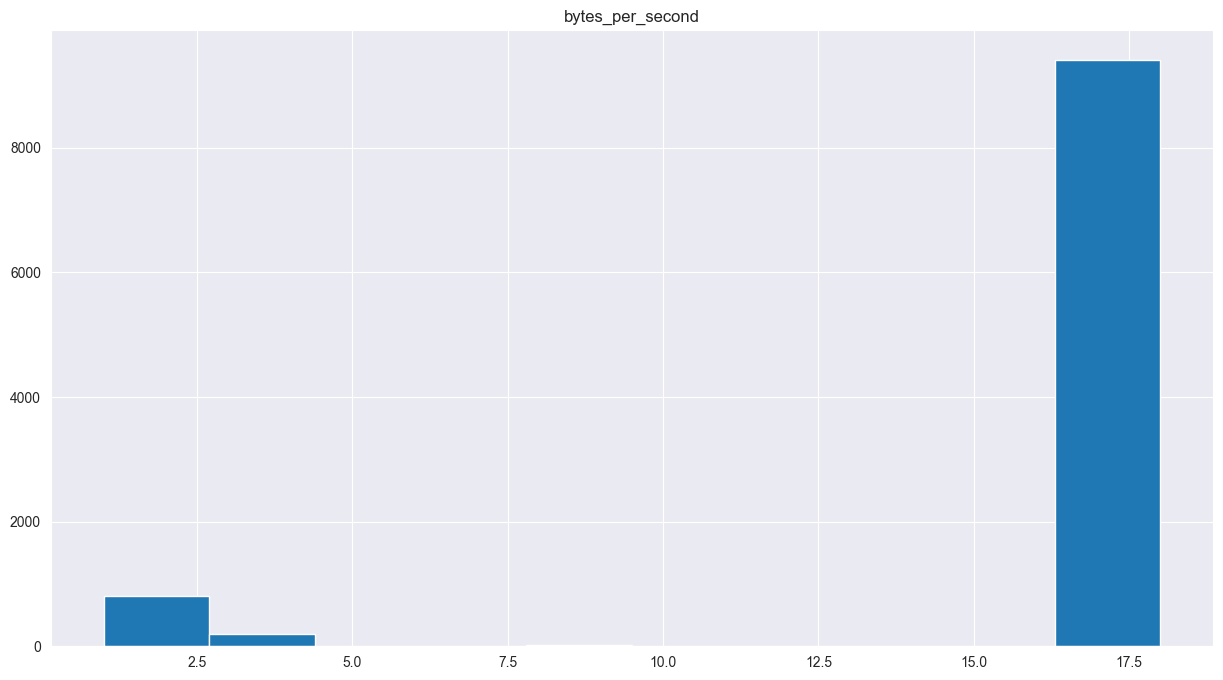

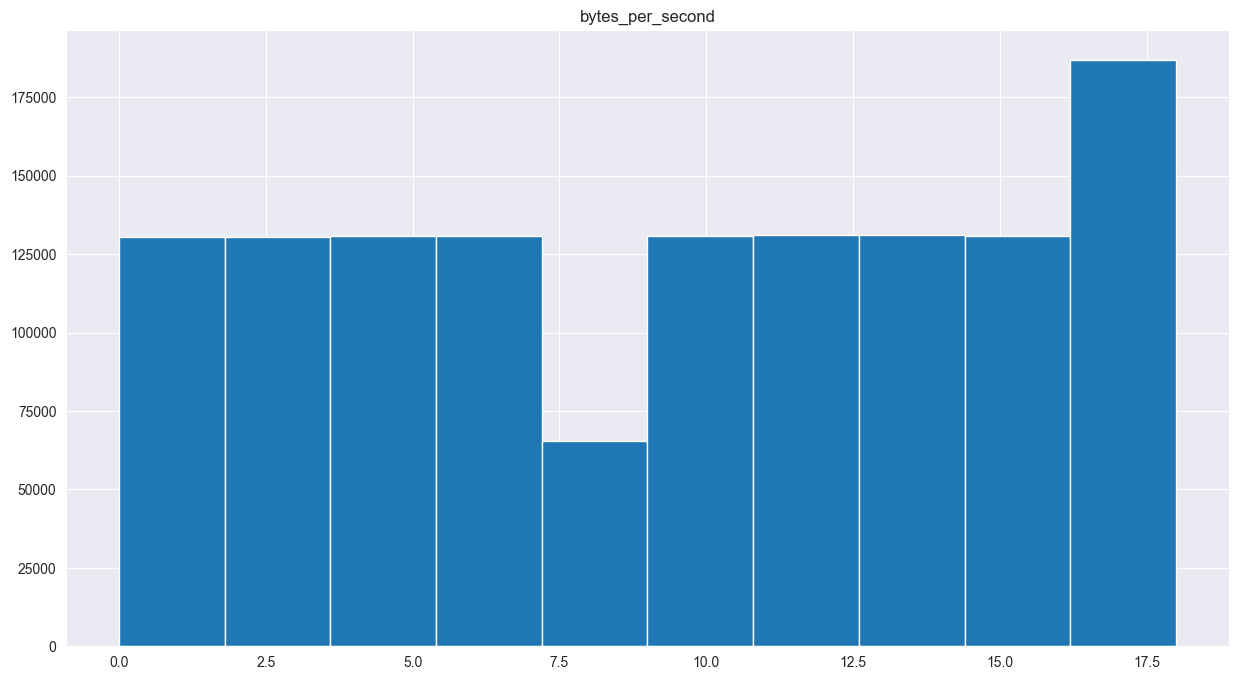

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# df1['bytes_per_second'] = df1['TotBytes'] / df1['Dur']

# Let's start by visualizinwg the 'TotBytes' and 'TotPkts' features
numeric_cols_infected[['TotBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_other[['TotBytes', 'Dur']].hist(bins=10, figsize=(15, 8))
plt.show()

numeric_cols_infected[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
numeric_cols_other[['bytes_per_second']].hist(bins=10, figsize=(15, 8))
plt.show()


### 1b. Discretize selected features

### 1c. Answers and explanation

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

### Learn model on infected host

In [74]:
botnet_ip = infected_hosts[0]
df_tracefile = df1[df1['SrcAddr'] == botnet_ip]
df_tracefile = df_tracefile.rename(columns={"State": "symb"})[['symb']]
print(len(df_tracefile))
flexfringe = FlexFringe(
    flexfringe_path="flexfringe-x64-windows.exe",
    heuristic_name="alergia",
    data_name="alergia_data",
    slidingwindow=1,
    swsize=10,
    sinkson=1,
    sinkcount=50,
    printblue=1,
    printwhite=1,
)

print('Loaded flexfringe')
# Learn a state machine
flexfringe.fit(df_tracefile,
               sinkson=1,
               sinkcount=50)
flexfringe.show()

9580
Loaded flexfringe


### Profiling

In [75]:
def make_profile(flex_fringe, trace_file):
    # Use state machine to predict likelihoods
    df = flex_fringe.predict(trace_file)
    return df[['abbadingo trace', 'state sequence']]

df1_profiling = df1[['SrcAddr', 'State']]
df1_profiling = df1_profiling.rename(columns={"State": "symb"})
df1_profiling = df1_profiling.groupby('SrcAddr').filter(lambda x: len(x) >= 20)
# Get the unique values in the 'SrcAddr' column
unique_src_addrs = df1_profiling['SrcAddr'].unique()
src_addr_with_state_trace = []
# Iterate over each unique 'SrcAddr' value
for src_addr in tqdm(unique_src_addrs, maxinterval=len(unique_src_addrs)):
    # Filter the dataframe based on the current 'SrcAddr' value
    filtered_df = df1_profiling[df1_profiling['SrcAddr'] == src_addr]
    trace_state = make_profile(flexfringe, filtered_df)
    src_addr_with_state_trace.append([src_addr, trace_state])

100%|██████████| 981/981 [07:12<00:00,  2.27it/s] 


In [76]:

# Create an empty dictionary to store the counts
counts = {}

# Iterate over each IP address and corresponding DataFrame
for item in tqdm(src_addr_with_state_trace, maxinterval=len(src_addr_with_state_trace)):
    ip_address = item[0]
    dataframe = item[1]

    # Iterate over each row in the DataFrame
    for _, row in dataframe.iterrows():
        states = row['state sequence']
        trace = row['abbadingo trace']

        # Get the shorter length between state sequence and abbadingo trace
        length = min(len(states), len(trace))

        # Iterate over each state and symbol combination
        for i in range(length):
            state = states[i]
            symbol = trace[i]

            # Cut off the state if it reaches -1
            if state == -1:
                break

            # Create a tuple representing the state and symbol combination
            combination = (state, symbol)

            # Update the counts dictionary
            if ip_address in counts:
                if combination in counts[ip_address]:
                    counts[ip_address][combination] += 1
                else:
                    counts[ip_address][combination] = 1
            else:
                counts[ip_address] = {combination: 1}

# Create a DataFrame from the counts dictionary
df_counts = pd.DataFrame(counts).fillna(0).astype(int).transpose()

# Sort the columns in ascending order
df_counts = df_counts.reindex(sorted(df_counts.columns), axis=1)

100%|██████████| 981/981 [00:16<00:00, 59.18it/s] 


In [85]:
cos_sim_matrix = cosine_similarity(df_counts)
# Convert the cosine similarity matrix to a DataFrame
df_cos_sim = pd.DataFrame(cos_sim_matrix, index=df_counts.index, columns=df_counts.index)

for ip_address in infected_hosts:
    print(ip_address)
    print(df_cos_sim.loc[botnet_ip, ip_address])


147.32.84.165
0.9999999999999969
147.32.84.191
0.9999469761157292
147.32.84.192
0.9999392541151741
147.32.84.193
0.999973872319286
147.32.84.204
0.9999167298534312
147.32.84.205
0.9998820210626371
147.32.84.206
0.9999161747191707
147.32.84.207
0.9999610774681784
147.32.84.208
0.9999225210472446
147.32.84.209
0.999973372457407


### 4b. Analysis and answers to the questions.

In [94]:
for index in df_cos_sim[df_cos_sim[botnet_ip] > 0.1][botnet_ip].index:
    if index not in infected_hosts:
        print(index)
        print(df_cos_sim[df_cos_sim[botnet_ip] > 0.1][botnet_ip][index])



In [79]:
# Separate the infected and non-infected IP addresses
infected_ips = set(infected_hosts)
non_infected_ips = set(df_counts.index) - infected_ips

# Calculate the occurrence percentages and counts for each state-symbol combination in infected and non-infected IP addresses
occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
total_count_infected = df_counts.loc[infected_ips].sum()
total_count_non_infected = df_counts.loc[non_infected_ips].sum()

# Filter state-symbol combinations that meet the conditions
significant_combinations = occurrence_infected[(occurrence_infected >= 0.85) & (occurrence_non_infected < 0.01)]

# Print the significant combinations along with their occurrence percentages and total counts
print("Significant state-symbol combinations:")
for combination, occurrence in significant_combinations.iteritems():
    count_infected = total_count_infected[combination]
    count_non_infected = total_count_non_infected[combination]
    print("Combination:", combination)
    print("Occurrence in infected IP addresses: {:.2f}%".format(occurrence * 100))
    print("Occurrence in non-infected IP addresses: {:.2f}%".format(occurrence_non_infected[combination] * 100))
    print()

Significant state-symbol combinations:
Combination: ('0', '')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.82%

Combination: ('0', 'AHA')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.72%

Combination: ('0', 'DCE')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.82%

Combination: ('0', 'DNP')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.72%

Combination: ('0', 'DNQ')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.72%

Combination: ('0', 'IAH')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.72%

Combination: ('0', 'MHR')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.72%

Combination: ('0', 'MRP')
Occurrence in infected IP addresses: 100.00%
Occurrence in non-infected IP addresses: 0.72%

Combination:

C:\Users\ottev\AppData\Local\Temp\ipykernel_7996\2396258940.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_infected = (df_counts.loc[infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_7996\2396258940.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  occurrence_non_infected = (df_counts.loc[non_infected_ips] > 0).mean()
C:\Users\ottev\AppData\Local\Temp\ipykernel_7996\2396258940.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_infected = df_counts.loc[infected_ips].sum()
C:\Users\ottev\AppData\Local\Temp\ipykernel_7996\2396258940.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  total_count_non_infected = df_counts.loc[non_infected_ips].sum()
C:\Users\ottev\AppDa

16756
11


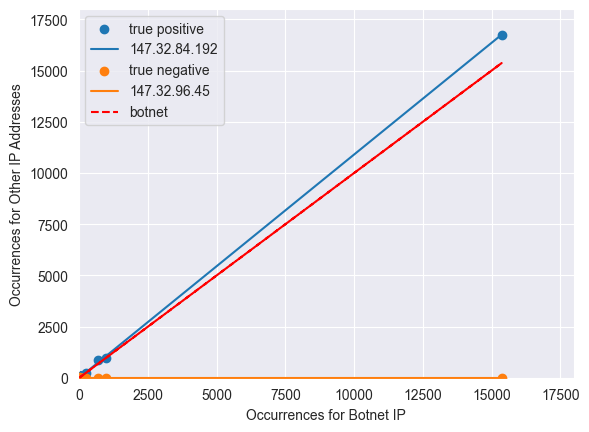

In [80]:
# Define the three IP addresses for the y-axis
ip_addresses = ['147.32.84.192', '147.32.96.45']
correctness = ['true positive', 'true negative']
# Get the occurrences for the botnet_ip row
botnet_occurrences = df_counts.loc[botnet_ip]

# Get the occurrences for the three given IP addresses
ip_occurrences = df_counts.loc[ip_addresses]

# Calculate the similarity scores for the three IP addresses
for ip_address in ip_addresses:
    print(max(ip_occurrences.loc[ip_address]))
    x = botnet_occurrences
    y = ip_occurrences.loc[ip_address]
    # Calculate the coefficients of the regression line (y = mx + c)
    coefficients = np.polyfit(x, y, 1)
    m = coefficients[0]  # Slope
    c = coefficients[1]  # Intercept

    # Generate points for the regression line
    regression_x = np.linspace(min(x), max(x), 100)
    regression_y = m * regression_x + c

    # Plot the data points and the regression line
    plt.scatter(x, y, label=correctness[ip_addresses.index(ip_address)])
    plt.plot(regression_x, regression_y, label=ip_address)

plt.plot(botnet_occurrences, botnet_occurrences, color='r', linestyle='--', label= 'botnet')
plt.xlabel('Occurrences for Botnet IP')
plt.ylabel('Occurrences for Other IP Addresses')
plt.xlim(-50, 18000)
plt.ylim(-50, 18000)
plt.legend()
# Show the plot
plt.show()


## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.

In [81]:
print(np.where(ip_occurrences.loc['147.32.87.16'].to_numpy() == (max(ip_occurrences.loc['147.32.87.16']))))
print(botnet_occurrences.to_numpy()[20])

KeyError: '147.32.87.16'